In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import flexcalc
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import numpy as np
import tomosipo as ts
import torch
from ts_algorithms import fdk

from autodiffCT.operator.basic import ApplyRoiOperator
from autodiffCT.optimizer import PyTorchOptimizer
from autodiffCT.pipeline import SequentialPipeline
from autodiffCT.tomography.project import BackprojectOperator
from autodiffCT.tomography.reconstruction import (
    PyTorchFbpOperator, PyTorchFdkOperator, PyTorchSirtOperator,
    ShiftRotationAxisOperator)

from autodiffCT.loss import VarianceLossFn


def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()
    plt.show()


class Logger:
    def __init__(self):
        self.loss_history = []
        self.shift_history = []
        self.recs = []
        self.shift = 0
    
    def log(self, optimizer_object):
        self.loss_history.append(optimizer_object.loss.item())
        self.shift_history.append(self.shift)
        self.shift = optimizer_object.pipeline.operators[0].parameters['shift'].value.item()
        if optimizer_object.iter_n % 10 == 0:
            self.recs.append(optimizer_object.output.detach().clone().cpu().squeeze())

# Load a CT scan of a walnut

The walnut dataset can be downloaded from zenodo here: https://zenodo.org/record/3763412. The paper uses 'walnut_01/good/' as a reconstruction.

Reading...


/export/scratch1/skorikov/miniconda3/envs/cortex/lib/python3.10/site-packages/imageio/plugins/tifffile.py:477: RuntimeWarning: Ignoring resulution metadata, because at least one direction has a 0 denominator.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 434.37files/s]


1 files were loaded. 79% memory left (53 GB).


100%|██████████| 2/2 [00:00<00:00, 203.11files/s]


2 files were loaded. 79% memory left (53 GB).


100%|██████████| 501/501 [00:01<00:00, 440.65files/s]
INFO:root:For det_tan: adjusting -24.0 by 24.
INFO:root:For src_ort: adjusting 91.4974 by -7.
INFO:root:For axs_tan: adjusting -150.0 by -0.5.
INFO:root:Adjusted vertical volume center to source/detector pos: z = 85.0814204827199.


501 files were loaded. 77% memory left (51 GB).
Reading geometry from 'scan settings.txt'
Pre-processing...
Done!


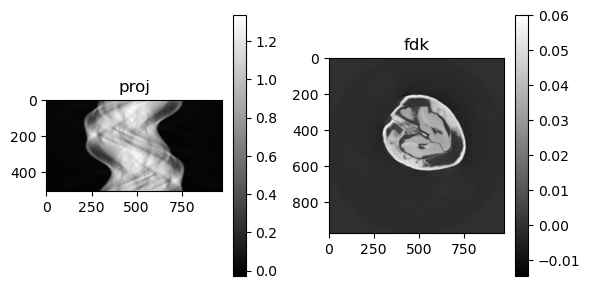

In [6]:
walnut_location = 'YOUR PATH TO WALNUT DATASET HERE'
proj, geom = flexcalc.process.process_flex(walnut_location, correct='cwi-flexray-2019-04-24')
geom['axs_tan'] = 0.0  # because of a bug in `tra_obj` parameter in `scan settings.txt`

central_slice_n = round(proj.shape[0]/2 + (geom['src_ort'] - geom['det_ort']))
proj = proj[[central_slice_n], :, ]
vg = ts.from_astra(geom.astra_volume_geom(vol_shape=[1, proj.shape[2], proj.shape[2]]))

pg = ts.from_astra(geom.astra_projection_geom(data_shape=proj.shape))
projector = ts.operator(vg, pg)

proj_data = torch.tensor(proj, device='cuda')

plot_imgs(proj=proj, fdk=fdk(projector, proj_data))

# Optionally add more rotation axis shift

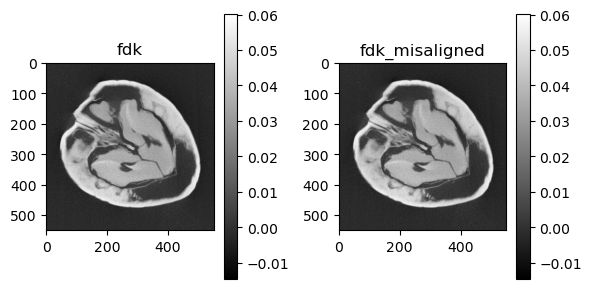

In [32]:
#No shift is applied here, start from original scan setup
AXIS_SHIFT = 0

proj_data_misaligned = torch.roll(proj_data, shifts=AXIS_SHIFT, dims=(2,))
rec_misaligned = projector.T(proj_data_misaligned)
roi = np.index_exp[0, 150:700, 250:800]

plot_imgs(fdk=fdk(projector, proj_data)[roi], fdk_misaligned=fdk(projector, proj_data_misaligned)[roi])

# Find the rotation axis shift by optimizing for the contrast of the reconstruction

In [33]:
roi = np.index_exp[0, 150:700, 250:800]

shift_axis_op = ShiftRotationAxisOperator(method='fourier')

pipeline = SequentialPipeline([
    shift_axis_op,
    BackprojectOperator(projector),
    # PyTorchFdkOperator(projector),
    # PyTorchSirtOperator(projector, n_iter=10),
    ApplyRoiOperator(roi)
])

lr = 25
optimizer_class = torch.optim.SGD
optimizer = PyTorchOptimizer(pipeline, optimizer_class,
                             target_parameters=[shift_axis_op.parameters['shift']],
                             lr=lr)

contrast_measure = VarianceLossFn()

logger = Logger()
optimal_shift = optimizer.optimize(loss_func=contrast_measure,
                                   inputs=[[proj_data_misaligned]],
                                   n_iterations=6, callback=logger.log)
optimal_shift

100%|██████████| 6/6 [00:00<00:00, 20.34it/s]


[tensor(-0.6801, requires_grad=True)]

Text(0.5, 1.0, 'Backprojection (after)')

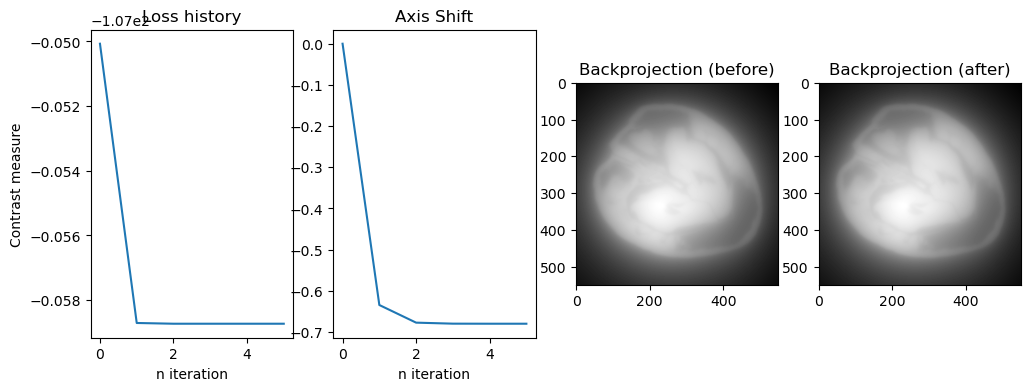

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].plot(logger.loss_history)
axes[0].set_xlabel('n iteration')
axes[0].set_ylabel('Contrast measure')
axes[0].set_title('Loss history')
axes[1].plot(logger.shift_history)
axes[1].set_xlabel('n iteration')
axes[1].set_title('Axis Shift')
axes[2].imshow(logger.recs[0])
axes[2].set_title('Backprojection (before)')
axes[3].imshow(logger.recs[-1])
axes[3].set_title('Backprojection (after)')

Text(0.5, 1.0, 'FDK (after)')

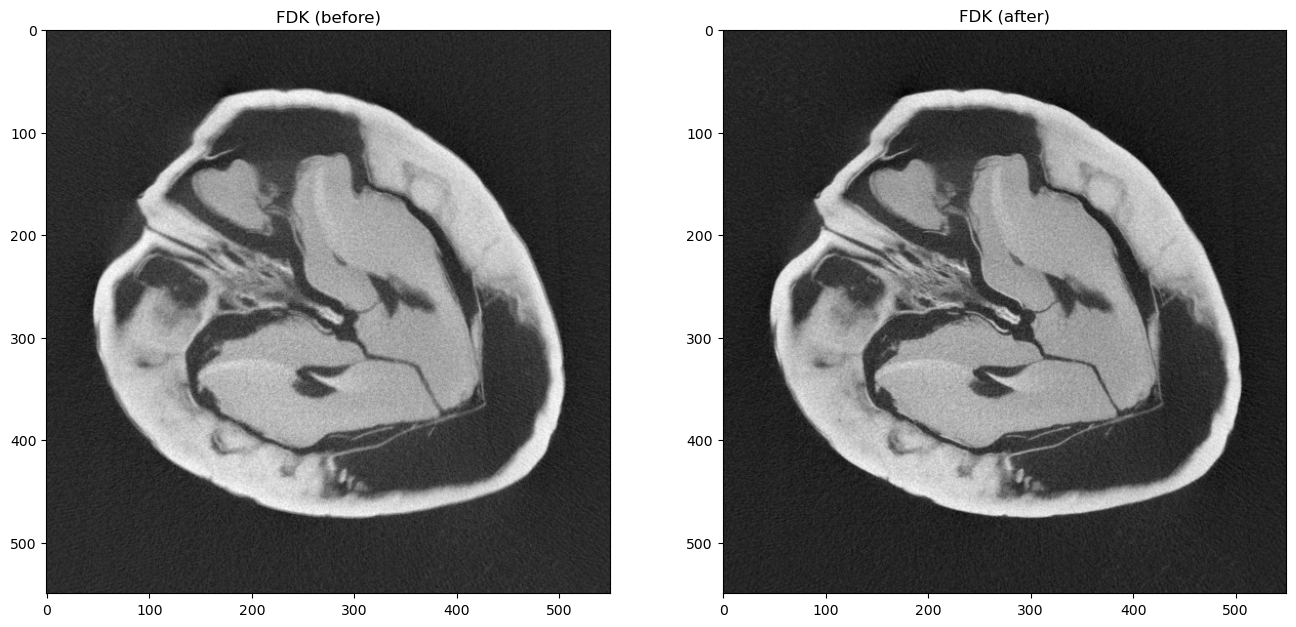

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fdk_before = fdk(projector, proj_data_misaligned)[roi].cpu().squeeze()
axes[0].imshow(fdk_before)
axes[0].set_title('FDK (before)')
fdk_after = fdk(projector, shift_axis_op(proj_data_misaligned))[roi].cpu().squeeze()
axes[1].imshow(fdk_after)
axes[1].set_title('FDK (after)')

Text(0.5, 1.0, 'FDK (aligned)')

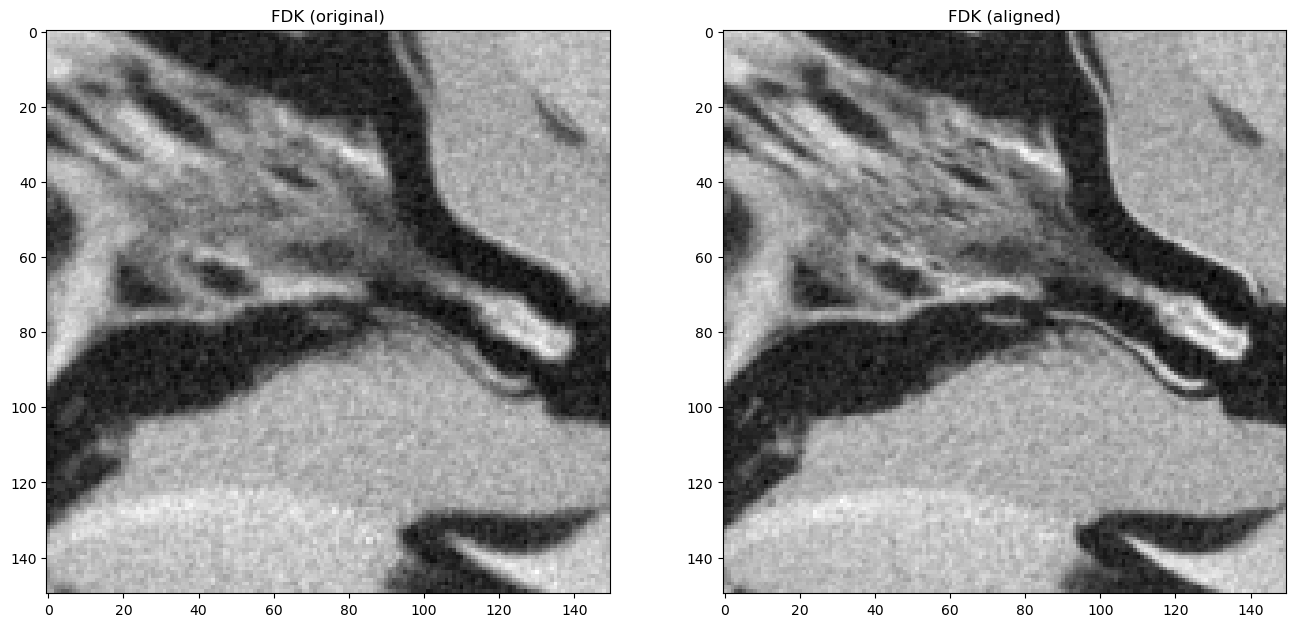

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
roi_zoomed = np.index_exp[350:500, 400:550]
fdk_original_zoom = fdk(projector, proj_data).cpu().squeeze()[roi_zoomed]
axes[0].imshow(fdk_original_zoom)
axes[0].set_title('FDK (original)')
fdk_before_zoom = fdk(projector, proj_data_misaligned).cpu().squeeze()[roi_zoomed]
fdk_after_zoom = fdk(projector, shift_axis_op(proj_data_misaligned)).cpu().squeeze()[roi_zoomed]
axes[1].imshow(fdk_after_zoom)
axes[1].set_title('FDK (aligned)')

# Save results

In [37]:
import os
from datetime import datetime


log_path = f'experimental_results/{datetime.today():%Y-%m-%d}'
os.makedirs(log_path, exist_ok=True)
np.savez_compressed(f'{log_path}/rotation_axis_alignment_walnut_results.npz',
                    lr=lr, optimizer=optimizer_class,
                    loss_fn=type(contrast_measure),
                    losses=logger.loss_history,
                    shifts=logger.shift_history,
                    fdk_before_full=fdk_before,
                    fdk_after_full=fdk_after,
                    fdk_before_zoom=fdk_before_zoom,
                    fdk_after_zoom=fdk_after_zoom)